In this notebook, I measure the number of qubits in a quantum token which are measured in the state $|0 \rangle$ after a rotation of $R(\theta_b, \phi_b)$ by the bank, followed by a unrotation of $R^{-1}(\theta_{a}, \phi_{a})$ by the faker. For a more detailed discussion of these results, please refer to section IV of  .

**Table of contents**<a id='toc0_'></a>    
- 1. [Protocol Execution](#toc1_)    
- 2. [Bloch Sphere Plot](#toc2_)    
- 3. [Results](#toc3_)    
  - 3.1. [Osaka](#toc3_1_)    
  - 3.2. [Brisbane](#toc3_2_)    
    - 3.2.1. [phi=0](#toc3_2_1_)    
    - 3.2.2. [phi=90](#toc3_2_2_)    
  - 3.3. [Kyoto](#toc3_3_)    
  - 3.4. [Kyiv](#toc3_4_)    
  - 3.5. [Sherbrooke](#toc3_5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12, "text.usetex": True, "font.family": "cmr"})

# definition of constants
z_a = np.array([-1, -.9, -.5, 0, .5, .9, 1])
phi_b = np.linspace(0, 2*np.pi, 9)
z_b = np.linspace(-1, 1, 9)
nb = 300

def na_analytical(theta_b, theta_a, phi_b, phi_a, c):
    """
    Analytical expression of the probability of the faker to measure the token in the |0> state, as defined in the paper.

    Parameters:
    z_b (float): The arccos of the angle of the RGate of the bank
    z_a (float): The arccos of the angle of the RGate of the faker
    phi_b (float): The phase of the RGate of the bank
    phi_a (float): The phase of the RGate of the faker
    n0 (float): The number of counts for the 0 state
    n1 (float): The number of counts for the 1 state

    Returns:
    float: The probability of the faker to measure the token in the |0> state
    """
    return 1/2 + c/2*(np.cos(theta_a)*np.cos(theta_b) + np.sin(theta_a)*np.sin(theta_b)*np.cos(phi_b - phi_a))

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

In [ ]:
# qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.timing_constraints import TimingConstraints

service = QiskitRuntimeService(channel="ibm_quantum", token="") #token ommited

def na_protocol(z_b, phi_b, z_a, phi_a=0):
    """
    Protocol that the bank creates a token state by a rotation with angles theta_b and phi_b, then the faker unrotates the token with theta_a and phi_a and measures it.

    Parameters:
    z_b (float): The arccos of the angle of the RGate of the bank
    phi_b (float): The phase of the RGate of the bank
    z_a (float): The arccos of the angle of the RGate of the faker
    phi_a (float): The phase of the RGate of the faker

    Returns:
    QuantumCircuit: The faker protocol to benchmark na
    """
    theta_b = np.arccos(z_b)
    theta_f = np.arccos(z_a)

    protocol = QuantumCircuit(QuantumRegister(1), ClassicalRegister(1))

    protocol.reset(0) # Bank initializes a qubit of the token
    protocol.append(RGate(theta_b, phi_b), [0]) # Bank prepares a qubit token state
    protocol.barrier()
    protocol.append(RGate(-theta_f, phi_a), [0]) # Faker unrotates the qubit
    protocol.measure(0, 0) # Faker Measures the qubit

    return protocol

def optmized_transpilation(backend, protocol, timing_constraints):
    """
    Transpile the protocol to the backend with the given timing constraints with optimal parameters previously tested
    
    Parameters:
    backend (osakaBackend): The backend to transpile the protocol
    protocol (QuantumCircuit): The quantum circuit to transpile
    timing_constraints (TimingConstraints): The timing constraints of the backend

    Returns:
    QuantumCircuit: The transpiled quantum circuit
    """
    pass_manager = generate_preset_pass_manager(optimization_level=0, # Optimization with inverse cancelation but no commutative cancellation
                                                backend=backend, # Use the backend to transpile
                                                layout_method='dense', # Take the qubit with longer T2 and smallest gate time
                                                routing_method='none', # As only one qubit is used, we don't need routing
                                                translation_method="translator", # Use the synthesis method to map the gates to the native operations of the backend, translator method can also be used but results in longer pulses
                                                approximation_degree=1, # No approximation of the gates
                                                timing_constraints=timing_constraints, # Use the timing constraints of the backend
                                            )
    return pass_manager.run(protocol)

def get_counts0(jobs):
    """
    Read the jobs and returns the counts at the |0> state.

    Parameters:
    jobs (list of Job): The list of jobs to calculate nq

    Returns:
    np.array: The counts at the |0> state
    """
    # Intialize empty arrays to store the mean and standard deviation of the results
    nb = np.empty(len(jobs), dtype=float)

    for itr in range(len(jobs)):

        counts = jobs[itr].result().get_counts() # Get the counts of the results
        nb[itr] = counts['0']

    return nb

# 1. <a id='toc1_'></a>[Protocol Execution](#toc0_)

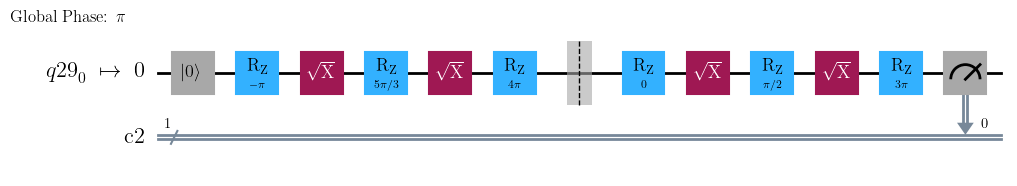

In [ ]:
backend = service.backend('ibm_brisbane')

# Get the time constrains of the backend for transpilation
backend_timing = backend.configuration().timing_constraints
timing_constraints = TimingConstraints(
                                        granularity=backend_timing['granularity'],
                                        min_length=backend_timing['min_length'],
                                        pulse_alignment=backend_timing['pulse_alignment'],
                                        acquire_alignment=backend_timing['acquire_alignment']
                                    )

optmized_transpilation(backend, na_protocol(z_b[2], phi_b[6], z_a[3], np.pi/2), timing_constraints).draw('mpl', idle_wires=False)

In [ ]:
transpiled_protocol = optmized_transpilation(backend, na_protocol(z_b[8], phi_b[1], z_a[5]), timing_constraints)
# Runs on the backend the transpiled protocol
backend.run(transpiled_protocol, shots=nb)

# 2. <a id='toc2_'></a>[Bloch Sphere Plot](#toc0_)

Here the analytical solution of $n_a$ for $c=1$ is ploted on the Bloch sphere.

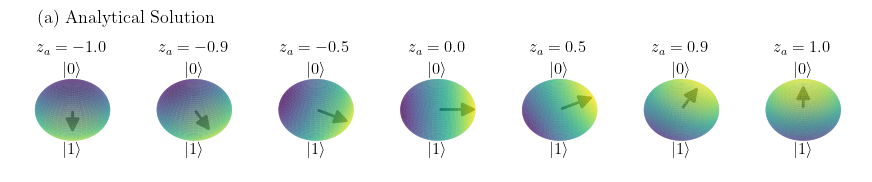

In [39]:
fig, axs = plt.subplots(1, 7, figsize=(11, 7), subplot_kw={'projection': '3d'})

theta_a = [180, 154, 120, 90, 60, 26, 0]

for i, ax in enumerate(axs):
    theta_grid, phi_grid = np.meshgrid(np.linspace(0, np.pi, 100), np.linspace(0, 2*np.pi, 100))

    x_grid = np.sin(theta_grid)*np.cos(phi_grid)
    y_grid = np.sin(theta_grid)*np.sin(phi_grid)
    z_grid = np.cos(theta_grid)

    arrow = Arrow3D(0, 0, 0, 1.1*(1-z_a[i]**2)**.5, 0, 1.1*z_a[i], arrowstyle="-|>", color='black', mutation_scale=20, lw=2)
    ax.add_artist(arrow)

    ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=.6, edgecolor='none', lw=0,
                    facecolors=plt.cm.viridis(np.array([[na_analytical(a, np.arccos(z_a[i]), b, 0, 0, 1) for a in np.linspace(0, np.pi, 100)] for b in np.linspace(0, 2*np.pi, 100)]).reshape(100,100)))

    ax.text(0, 0, 1.6, r'$|0\rangle$', color='black', fontsize=12, ha='center', va='center')
    ax.text(0, 0, -1.7, r'$|1\rangle$', color='black', fontsize=12, ha='center', va='center')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_axis_off()
    ax.view_init(elev=30, azim=270)
    # ax.set_title(r'$\theta_{a} = $' + f'{theta_a[i]}$^\circ$', y=.98, fontsize=12)
    ax.set_title(f'$z_a = {z_a[i]:.1f}$', fontsize=12, y=1)

fig.suptitle('(a) Analytical Solution', fontsize=13, va='top', x=0.15, y=.64, ha='left') 

fig.subplots_adjust(wspace=0)
fig.savefig('./figures/bloch_na.pdf', bbox_inches='tight', transparent=True)

# 3. <a id='toc3_'></a>[Results](#toc0_)

The experimental results for $n_a$ as a function of the attacker and bank angles are loaded and ploted for the five IBMQ.

## 3.1. <a id='toc3_1_'></a>[Osaka](#toc0_)

In [2]:
na_osaka = np.empty(9, dtype=object)

for itr_za in range(7):
    na_osaka[itr_za] = np.loadtxt(f'./exp_data/osaka/na/na_za_{z_a[itr_za]:.1f}.txt')

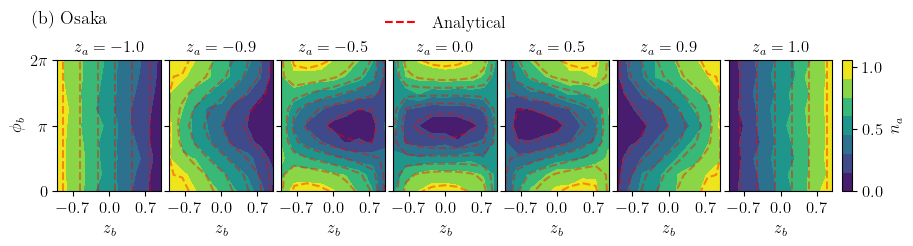

In [22]:
fig, axs = plt.subplots(1, 7, figsize=(10, 1.7), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
# axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_osaka[itr][:,2].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1)
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(a), np.arccos(z_a[itr]), b, 0, 0.8959943586043012) for a in z_b] for b in phi_b]).reshape(9,9), vmin=0, vmax=1, colors='r', alpha=.4, linestyles='dashed', levels=5
                     )
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_osaka[0][:,2].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[0, .5, 1]
                    )
fig.suptitle('(b) Osaka', fontsize=13, va='top', x=0.1, y=1.17, ha='left') 
fig.subplots_adjust(wspace=.08)

axs[3].plot([0], [0], label='Analytical', color='r', linestyle='dashed')
axs[3].legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.45), frameon=False)

fig.savefig('./figures/na_osaka.pdf', bbox_inches='tight', transparent=True)

## 3.2. <a id='toc3_2_'></a>[Brisbane](#toc0_)

### 3.2.1. <a id='toc3_2_1_'></a>[phi=0](#toc0_)

In [37]:
na_brisbane_phi0 = np.empty(9, dtype=object)

for itr_za in range(len(z_a)):
    na_brisbane_phi0[itr_za] = np.loadtxt(f'./exp_data/brisbane/na_phi0/na_za_{z_a[itr_za]:.1f}.txt')

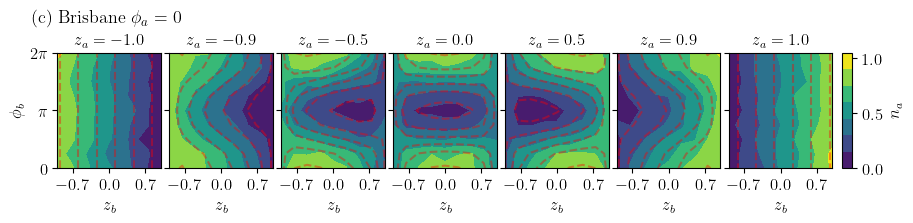

In [51]:
fig, axs = plt.subplots(1, 7, figsize=(10, 1.5), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_brisbane_phi0[itr].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1)
    
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(a), np.arccos(z_a[itr]), b, 0, 0.843234615325578) for a in z_b] for b in phi_b]).reshape(9,9), vmin=0, vmax=1, colors='r', alpha=.4, linestyles='dashed', levels=5)
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_brisbane_phi0[0].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[0, .5, 1]
                    )
fig.suptitle(r'(c) Brisbane $\phi_a = 0$', fontsize=13, va='top', x=0.1, y=1.17, ha='left')
fig.subplots_adjust(wspace=0.08) 

fig.savefig('./figures/na_brisbane_phi0.pdf', bbox_inches='tight', transparent=True)

### 3.2.2. <a id='toc3_2_2_'></a>[phi=90](#toc0_)

In [39]:
na_brisbane_phi90 = np.empty(9, dtype=object)

for itr_za in range(len(z_a)):
    na_brisbane_phi90[itr_za] = np.loadtxt(f'./exp_data/brisbane/na_phi90/na_za_{z_a[itr_za]:.1f}.txt')

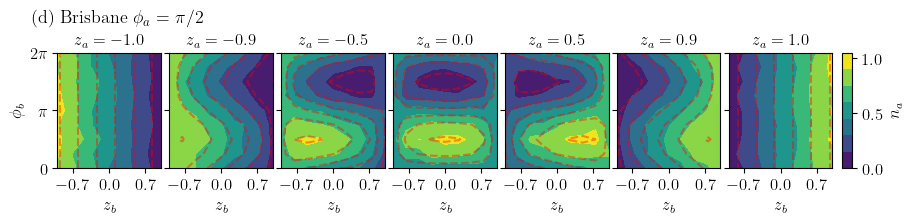

In [50]:
fig, axs = plt.subplots(1, 7, figsize=(10,1.5), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_brisbane_phi90[itr].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1)
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(a), np.arccos(z_a[itr]), b, np.pi/2, 0.843234615325578) for a in z_b] for b in phi_b]).reshape(9,9), vmin=0, vmax=1, colors='r', alpha=.4, linestyles='dashed', levels=5)
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_brisbane_phi90[0].reshape(9, 9)/300, cmap='viridis', vmin=0, vmax=1),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[0, .5, 1]
                    )
fig.suptitle(r'(d) Brisbane $\phi_a = \pi/2$', fontsize=13, va='top', x=0.1, y=1.17, ha='left')
fig.subplots_adjust(wspace=0.08) 

fig.savefig('./figures/na_brisbane_phi90.pdf', bbox_inches='tight', dpi=300, transparent=True)

## 3.3. <a id='toc3_3_'></a>[Kyoto](#toc0_)

In [43]:
na_kyoto = np.empty(7, dtype=object)

for itr_za in range(7):
    na_kyoto[itr_za] = np.loadtxt(f'./exp_data/kyoto/na/na_za_{z_a[itr_za]:.1f}.txt')

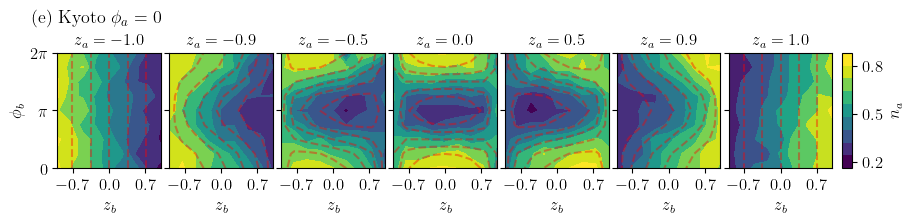

In [49]:
fig, axs = plt.subplots(1, 7, figsize=(10, 1.5), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_kyoto[itr].reshape(9, 9)/300, cmap='viridis', vmin=0.2, vmax=0.8)
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(zb), np.arccos(z_a[itr]), phib, 0, 0.5630934365017465) for zb in z_b] for phib in phi_b]).reshape(9,9), vmin=.2, vmax=.8, colors='r', alpha=.4, linestyles='dashed', levels=5)
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_kyoto[0].reshape(9, 9)/300, cmap='viridis', vmin=0.2, vmax=0.8),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[.2, .5, .8]
                    )
fig.suptitle(r'(e) Kyoto $\phi_a=0$', fontsize=13, va='top', x=0.1, y=1.17, ha='left') 
fig.subplots_adjust(wspace=0.08)

fig.savefig('./figures/na_kyoto.pdf', bbox_inches='tight', dpi=300, transparent=True
            )

## 3.4. <a id='toc3_4_'></a>[Kyiv](#toc0_)

In [31]:
na_kyiv = np.empty(7, dtype=object)

for itr_za in range(7):
    na_kyiv[itr_za] = np.loadtxt(f'./exp_data/kyiv/na/na_za_{z_a[itr_za]:.1f}.txt')

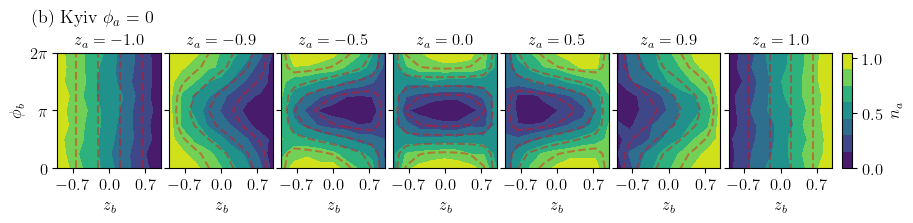

In [48]:
fig, axs = plt.subplots(1, 7, figsize=(10, 1.5), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_kyiv[itr].reshape(9, 9)/300, cmap='viridis')
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(zb), np.arccos(z_a[itr]), phib, 0, 0.9503942133692314) for zb in z_b] for phib in phi_b]).reshape(9,9),colors='r', alpha=.4, linestyles='dashed', levels=5)
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_kyiv[0].reshape(9, 9)/300, cmap='viridis'),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[0, .5, 1]
                    )
fig.suptitle(r'(b) Kyiv $\phi_a=0$', fontsize=13, va='top', x=0.1, y=1.17, ha='left') 
fig.subplots_adjust(wspace=0.08)

fig.savefig('./figures/na_kyiv.pdf', bbox_inches='tight', dpi=300, transparent=True)

## 3.5. <a id='toc3_5_'></a>[Sherbrooke](#toc0_)

In [2]:
na_sherbrooke = np.empty(7, dtype=object)

for itr_za in range(7):
    na_sherbrooke[itr_za] = np.loadtxt(f'./exp_data/sherbrooke/na/na_za_{z_a[itr_za]:.1f}.txt')

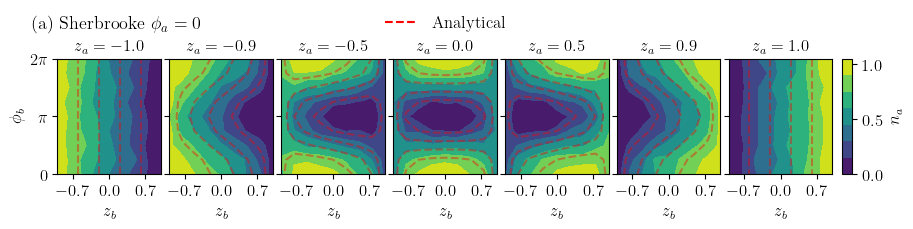

In [4]:
fig, axs = plt.subplots(1, 7, figsize=(10, 1.5), sharey=True, sharex=True)    

axs[0].set_xlabel(r'$z_b$')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\phi_b$')
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_xticks([-.7, 0, .7])

for itr in range(7):
    axs[itr].contourf(z_b, phi_b, na_sherbrooke[itr].reshape(9, 9)/300, cmap='viridis')
    axs[itr].contour(z_b, phi_b, np.array([[na_analytical(np.arccos(zb), np.arccos(z_a[itr]), phib, 0, 0.9859975714946958) for zb in z_b] for phib in phi_b]).reshape(9,9),colors='r', alpha=.4, linestyles='dashed', levels=5)
    axs[itr].set_xlabel(r'$z_b$')
    axs[itr].set_title(f'$z_a={z_a[itr]}$', fontsize=12)

cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(fig.axes[-1].contourf(z_b, phi_b, na_sherbrooke[0].reshape(9, 9)/300, cmap='viridis'),
                    cax=cbar_ax,
                    label=r'$n_a$',
                    ticks=[0, .5, 1]
                    )
fig.suptitle(r'(a) Sherbrooke $\phi_a=0$', fontsize=13, va='top', x=0.1, y=1.17, ha='left') 
fig.subplots_adjust(wspace=0.08)
axs[3].plot([0], [0], label='Analytical', color='r', linestyle='dashed')
axs[3].legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.5), frameon=False)

fig.savefig('./figures/na_sherbrooke.pdf', bbox_inches='tight', dpi=300, transparent=True)